In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import os
import random
import shutil
import cv2
from PIL import Image
import numpy as np
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/deep_learning')

In [12]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_set = torchvision.datasets.ImageFolder("train", transform=transform)
val_set = torchvision.datasets.ImageFolder("val", transform=transform)
test_set = torchvision.datasets.ImageFolder("test", transform=transform)

In [14]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

### Transfer Learning - VGG16

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.parameters(), lr=0.001)

In [16]:
if torch.cuda.is_available():
  print('Runnning with GPU')
else:
  print('Runnning with CPU')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Runnning with GPU


In [ ]:

model_vgg16.to(device)

num_epochs = 25
train_loss_vgg = []

for epoch in range(num_epochs):
    model_vgg16.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_set)
    train_loss_vgg.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/25 - Loss: 2.9957
Epoch 2/25 - Loss: 0.6920
Epoch 3/25 - Loss: 0.7025
Epoch 4/25 - Loss: 0.6416
Epoch 5/25 - Loss: 0.6704
Epoch 6/25 - Loss: 0.7079
Epoch 7/25 - Loss: 0.7034
Epoch 8/25 - Loss: 0.6965
Epoch 9/25 - Loss: 0.7023
Epoch 10/25 - Loss: 0.7018
Epoch 11/25 - Loss: 0.7012
Epoch 12/25 - Loss: 0.7059
Epoch 13/25 - Loss: 0.6963
Epoch 14/25 - Loss: 0.6979
Epoch 15/25 - Loss: 0.7005
Epoch 16/25 - Loss: 0.7005
Epoch 17/25 - Loss: 0.6965
Epoch 18/25 - Loss: 0.6937
Epoch 19/25 - Loss: 0.6975
Epoch 20/25 - Loss: 0.6956
Epoch 21/25 - Loss: 0.6983
Epoch 22/25 - Loss: 0.7014
Epoch 23/25 - Loss: 0.6948
Epoch 24/25 - Loss: 0.6927
Epoch 25/25 - Loss: 0.6953


In [ ]:
torch.save(model_vgg16.state_dict(), 'melanoma_vgg16.pth')

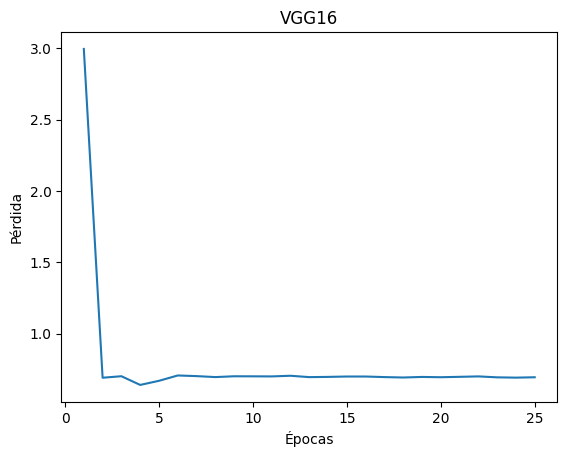

In [ ]:
plt.figure()
plt.title("VGG16")
plt.plot(range(1, len(train_loss_vgg)+1), train_loss_vgg)
# plt.axis([0, len(train_loss_vgg)+1, 0, 0.5])
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.show()

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [19]:
# LOAD MODEL
model_saved = models.vgg16() 
model_saved.load_state_dict(torch.load('melanoma_vgg16.pth'))  
model_saved.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
val_accuracy = evaluate(model_vgg16, val_loader)
test_accuracy = evaluate(model_vgg16, test_loader)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.5337
Test Accuracy: 0.5333


In [ ]:
model_vgg16.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

f1 = f1_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')

print("F1-score:", f1)
print("Recall:", recall)
print("Precisión:", precision)

F1-score: 0.6956521739130436
Recall: 0.5333333333333333
Precisión: 0.28444444444444444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0 168]
 [  0 192]]


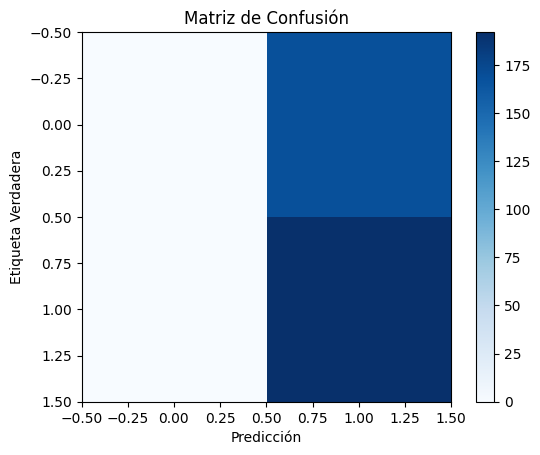

In [20]:
# model_vgg16.eval()
model_saved.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_saved(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)

print(cm)

# Mostrar la matriz de confusión en forma de gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

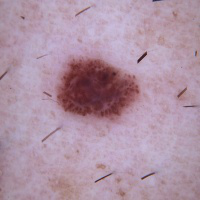

In [ ]:
image_path = "melanoma/ISIC_0024410.jpg"
# image_path = "reduced-non-melanoma/ISIC_0032411.jpg"
image = Image.open(image_path)

image

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((150, 150)),  # Ajusta al tamaño esperado por el modelo
    transforms.ToTensor(),  # Convierte la imagen a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de valores de píxeles
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

input_tensor = input_tensor.to(device)
input_batch = input_batch.to(device)

In [ ]:
model_vgg16.eval()

# Realiza la predicción
with torch.no_grad():
    output = model_vgg16(input_batch)

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class_index = torch.argmax(probabilities).item()

In [ ]:
predicted_class_index

1

### Transfer Learning - ResNet50

In [ ]:
model_resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer = optim.Adam(model_resnet50.parameters(), lr=0.002)

In [ ]:
model_resnet50.to(device)

num_epochs = 25
train_loss_res = []

for epoch in range(num_epochs):
    model_resnet50.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet50(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_set)
    train_loss_res.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/25 - Loss: 0.8871
Epoch 2/25 - Loss: 0.6163
Epoch 3/25 - Loss: 0.5476
Epoch 4/25 - Loss: 0.5309
Epoch 5/25 - Loss: 0.5381
Epoch 6/25 - Loss: 0.5280
Epoch 7/25 - Loss: 0.5074
Epoch 8/25 - Loss: 0.4796
Epoch 9/25 - Loss: 0.4689
Epoch 10/25 - Loss: 0.4529
Epoch 11/25 - Loss: 0.4744
Epoch 12/25 - Loss: 0.4451
Epoch 13/25 - Loss: 0.4547
Epoch 14/25 - Loss: 0.4598
Epoch 15/25 - Loss: 0.4697
Epoch 16/25 - Loss: 0.4705
Epoch 17/25 - Loss: 0.4256
Epoch 18/25 - Loss: 0.4470
Epoch 19/25 - Loss: 0.4143
Epoch 20/25 - Loss: 0.3963
Epoch 21/25 - Loss: 0.3865
Epoch 22/25 - Loss: 0.3781
Epoch 23/25 - Loss: 0.3852
Epoch 24/25 - Loss: 0.3406
Epoch 25/25 - Loss: 0.3316


In [ ]:
torch.save(model_resnet50.state_dict(), 'melanoma_resnet50.pth')

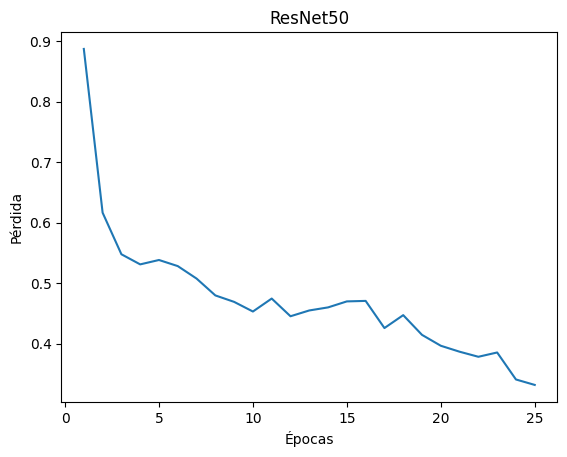

In [ ]:
plt.figure()
plt.title("ResNet50")
plt.plot(range(1, len(train_loss_res)+1), train_loss_res)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.show()

In [21]:
# LOAD MODEL
model_saved = models.resnet50() 
model_saved.load_state_dict(torch.load('melanoma_resnet50.pth'))  
model_saved.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
val_accuracy = evaluate(model_resnet50, val_loader)
test_accuracy = evaluate(model_resnet50, test_loader)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.7022
Test Accuracy: 0.7611


In [ ]:
model_resnet50.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_resnet50(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

f1 = f1_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')

print("F1-score:", f1)
print("Recall:", recall)
print("Precisión:", precision)

F1-score: 0.75
Recall: 0.7611111111111111
Precisión: 0.7779520917678813


[[145  23]
 [ 63 129]]


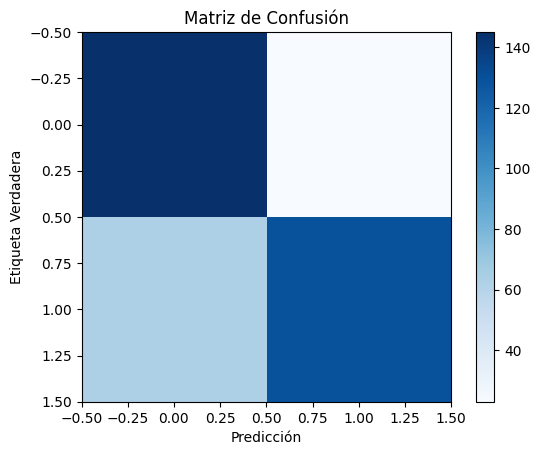

In [24]:
# model_resnet50.eval()
model_saved.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_saved(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
print(cm)

# Mostrar la matriz de confusión en forma de gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

In [ ]:
model_resnet50.eval()

# Realiza la predicción
with torch.no_grad():
    output = model_resnet50(input_batch)

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class_index = torch.argmax(probabilities).item()

In [ ]:
predicted_class_index

0

### Transfer Learning - GoogleNet

In [ ]:
model_googlenet = models.googlenet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
optimizer = optim.Adam(model_googlenet.parameters(), lr=0.002)

In [ ]:
model_googlenet.to(device)

num_epochs = 25
train_loss_googlenet = []

for epoch in range(num_epochs):
    model_googlenet.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_googlenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_set)
    train_loss_googlenet.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/25 - Loss: 0.8360
Epoch 2/25 - Loss: 0.5482
Epoch 3/25 - Loss: 0.5139
Epoch 4/25 - Loss: 0.4701
Epoch 5/25 - Loss: 0.4655
Epoch 6/25 - Loss: 0.4347
Epoch 7/25 - Loss: 0.4420
Epoch 8/25 - Loss: 0.4348
Epoch 9/25 - Loss: 0.4156
Epoch 10/25 - Loss: 0.3901
Epoch 11/25 - Loss: 0.3761
Epoch 12/25 - Loss: 0.3733
Epoch 13/25 - Loss: 0.3460
Epoch 14/25 - Loss: 0.3497
Epoch 15/25 - Loss: 0.3180
Epoch 16/25 - Loss: 0.2803
Epoch 17/25 - Loss: 0.2603
Epoch 18/25 - Loss: 0.2542
Epoch 19/25 - Loss: 0.2291
Epoch 20/25 - Loss: 0.2271
Epoch 21/25 - Loss: 0.2291
Epoch 22/25 - Loss: 0.2311
Epoch 23/25 - Loss: 0.2016
Epoch 24/25 - Loss: 0.1545
Epoch 25/25 - Loss: 0.2419


In [ ]:
torch.save(model_googlenet.state_dict(), 'melanoma_googlenet.pth')

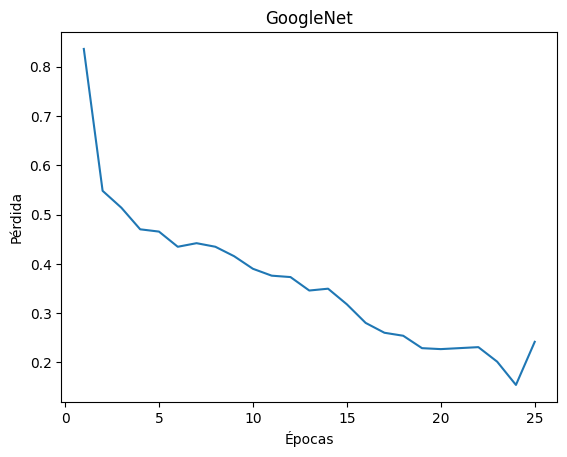

In [ ]:
plt.figure()
plt.title("GoogleNet")
plt.plot(range(1, len(train_loss_googlenet)+1), train_loss_googlenet)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.show()

In [29]:
# LOAD MODEL
model_saved_gn = models.googlenet(pretrained=True) 
model_saved_gn.load_state_dict(torch.load('melanoma_googlenet.pth'))  
model_saved_gn.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
val_accuracy = evaluate(model_googlenet, val_loader)
test_accuracy = evaluate(model_googlenet, test_loader)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Validation Accuracy: 0.7725
Test Accuracy: 0.7556


In [ ]:
model_googlenet.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_googlenet(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

f1 = f1_score(true_labels, predictions)
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')

print("F1-score:", f1)
print("Recall:", recall)
print("Precisión:", precision)

F1-score: 0.7924528301886793
Recall: 0.7555555555555555
Precisión: 0.7653735632183908


[[104  64]
 [ 24 168]]


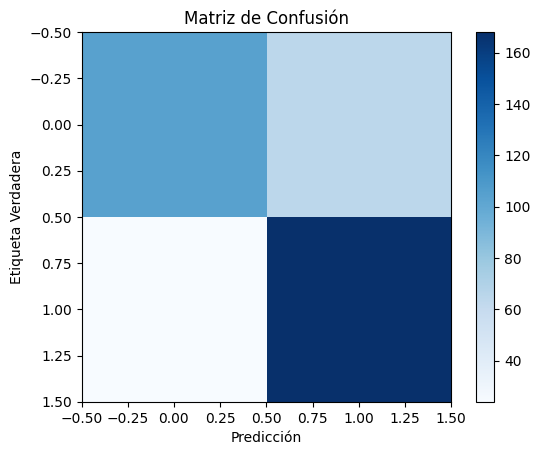

In [31]:
# model_googlenet.eval()
model_saved_gn.eval()

predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_saved_gn(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Generar la matriz de confusión
cm = confusion_matrix(true_labels, predictions)
print(cm)

# Mostrar la matriz de confusión en forma de gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.colorbar()
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

In [ ]:
model_googlenet.eval()

# Realiza la predicción
with torch.no_grad():
    output = model_googlenet(input_batch)

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class_index = torch.argmax(probabilities).item()

In [ ]:
predicted_class_index

0

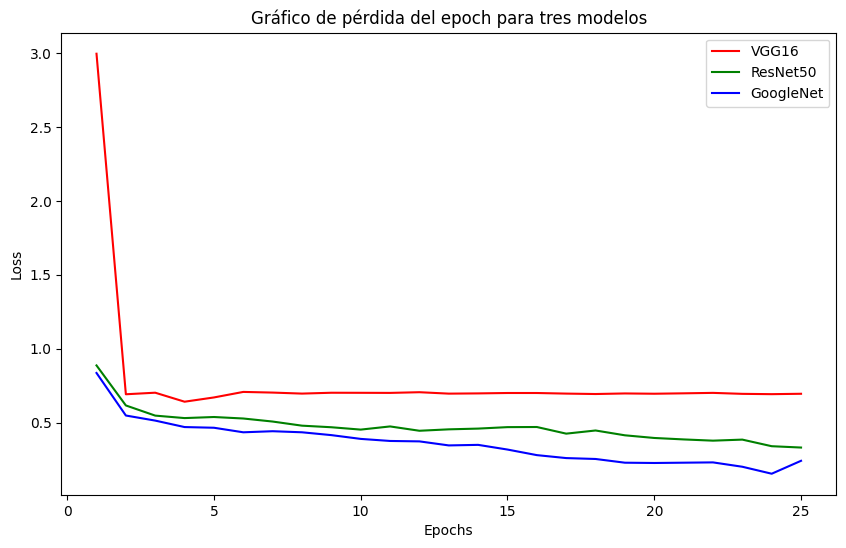

In [ ]:
epochs = 25

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_loss_vgg, 'r-', label='VGG16')
plt.plot(range(1, epochs+1), train_loss_res, 'g-', label='ResNet50')
plt.plot(range(1, epochs+1), train_loss_googlenet, 'b-', label='GoogleNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Gráfico de pérdida del epoch para tres modelos')
plt.legend()